In [449]:
import torch
import numpy as np
import torchvision.datasets as datasets
import torchvision
from tqdm import tqdm
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [450]:
# import a trained ResNet model for ILSVRC 2012
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
# model  = resnet50(pretrained=True)

In [451]:
def normalize(image):
    norm = (image - image.mean())/image.std()
    norm = norm * 0.1
    norm = norm + 0.5
    norm = norm.clip(0, 1)
    return norm

In [452]:
# iterate over files in the Dataset Directory
imgs = [Image.open('Dataset/' + path) for path in os.listdir('Dataset')]

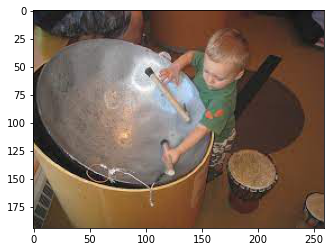

In [453]:
plt.imshow(imgs[0])
to_tensor = transforms.ToTensor()
data = [to_tensor(img) for img in imgs]

In [454]:
## Extract labels from file named 'imagenet_labels.txt'
labels = []
for line in open('imagenet_labels.txt'):
    labels.append(line.strip())

In [455]:
# Preprocess the image by making it a single batch of size 1 and passing it through the Resnet
unsqueeze = transforms.Lambda(lambda x: x.unsqueeze(0))
X = [unsqueeze(img) for img in data]
X[0].requires_grad = True # set the requires_grad attribute to True
op = model(X[0])
print(op.shape)

torch.Size([1, 1000])


In [456]:
# Get the index of the maximum value in the output vector
index = op.argmax().item()
print(index)
print(labels[index])

876
tub


In [457]:
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [458]:
def vanilla_backprop(image, model):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    global labels
    image.requires_grad = True
    if (image.grad is not None):
        image.grad.data.zero_()
    model.zero_grad()
    op  = model(image)
    index = op.argmax().item()
    label = labels[index]
    img = image.clone().detach()
    ax[0].imshow(img[0].permute(1, 2, 0))
    # compute the backpropagation of the max softmax probability
    op[0, index].backward()
    # get the gradients
    grad = image.grad.data[0]
    ax[1].imshow(normalize(grad.permute(1, 2, 0)))
    ax[1].set_title('Vanilla Backpropagation')
    ax[0].set_title('Original Image')

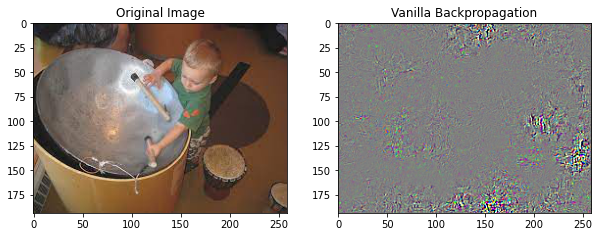

In [459]:
vanilla_backprop(X[0], model)

In [460]:
feature_maps = []

In [461]:
# defibne custom backward hook 

def backward_hook(module, grad_in, grad_out):
    if(isinstance(module, torch.nn.ReLU)):
        return (torch.clamp(grad_in[0], min=0.0),) # gradient clamped at negative values to zero

In [462]:
# set the hook to the model
def set_backward_hooks(model):
    for name, module in model.named_modules():
        if(isinstance(module, torch.nn.ReLU)):
            module.register_backward_hook(backward_hook)
            print("Backward Hooked", name)
            

In [463]:
def forward_hook(module, input, output):
    global feature_maps
    if(isinstance(module, torch.nn.modules.pooling.AdaptiveAvgPool2d)):
        feature_maps.append(input)
    return output

In [464]:
def set_forward_hooks(model):
    features = []
    for name, module in model.named_modules():
        if(isinstance(module, torch.nn.modules.pooling.AdaptiveAvgPool2d)):
            module.register_forward_hook(forward_hook)
            print("Forward Hooked", name)

In [465]:
def guided_backprop(image, model):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    global labels
    global feature_maps
    global backward_hook
    global set_backward_hooks
    
    # apply the Hooks onto the model and Zero the gradients
    image.requires_grad = True
    image.grad.data.zero_()
    model.zero_grad()
    set_backward_hooks(model)      

    # compute output
    op  = model(image)
    index = op.argmax().item()
    label = labels[index]
    
    # show the original image
    img = image.clone().detach()
    ax[0].imshow(img[0].permute(1, 2, 0))
    
    # compute the backpropagation of the max softmax probability
    op[0, index].backward()
    
    # get the gradients
    grad = image.grad.data[0]
    
    ax[1].imshow(normalize(grad.permute(1, 2, 0)))
    ax[1].set_title('Guided Backpropagation')
    ax[0].set_title('Original Image')
    return grad

### Guided Backpropagation 

To do this we need to set the gradients to zero wherever the gradients contribute negatively to the softmax probability 
of the predicted class

Backward Hooked relu
Backward Hooked layer1.0.relu
Backward Hooked layer1.1.relu
Backward Hooked layer1.2.relu
Backward Hooked layer2.0.relu
Backward Hooked layer2.1.relu
Backward Hooked layer2.2.relu
Backward Hooked layer2.3.relu
Backward Hooked layer3.0.relu
Backward Hooked layer3.1.relu
Backward Hooked layer3.2.relu
Backward Hooked layer3.3.relu
Backward Hooked layer3.4.relu
Backward Hooked layer3.5.relu
Backward Hooked layer4.0.relu
Backward Hooked layer4.1.relu
Backward Hooked layer4.2.relu


/home/arkartik/anaconda3/envs/adaenv/lib/python3.9/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


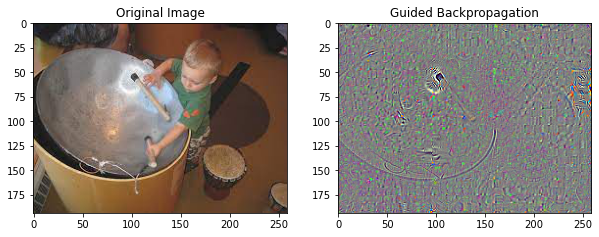

In [466]:
grad = guided_backprop(X[0], model)

### Class Activation Maps

---

In order to make the class activation maps useful one must extract the layer weights and activations from the model


$$
\begin{align}
    M_{x,y} &= \sum_{k=1}^{K} W_{c,k} \cdot A_{k,x,y} \\
    &= A_{x, y , :} \cdot \vec{W}_{c, :} \\
\end{align}
$$

In [467]:
def get_CAM(pre_pool_weight, final_weights, index, input_size):
    channels, height, width = pre_pool_weight.shape # 2048, 7, 9
    cam = np.zeros((height, width), dtype=np.float32)
    for i in range(channels):
        cam += pre_pool_weight[i, :, :] * final_weights[index, i] # matrix into scalar multiplication
    # now we must upsample the cam to the size of the input image
    cam = np.maximum(cam, 0) # ReLU can be done here (it is usually done)
    return cv2.resize(cam, (input_size[1], input_size[0]))

In [468]:
def CAM(image, model):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    global labels
    global feature_maps
    global backward_hook
    global set_backward_hooks
    
    # apply the Hooks onto the model and Zero the gradients
    image.requires_grad = True
    image.grad.data.zero_()
    model.zero_grad()
    set_forward_hooks(model)  

    # compute output
    op  = model(image)
    index = op.argmax().item()
    label = labels[index]
    
    # show the original image
    img = image.clone().detach()
    ax[0].imshow(img[0].permute(1, 2, 0))
    
    # compute the backpropagation of the max softmax probability
    op[0, index].backward()
    
    # get the weights that are needed
    pre_pool_weight = feature_maps[0][0].detach().numpy()[0]
    final_weights = model.fc.weight.detach().numpy()
    input_size = image.shape[2:]
    
    print(pre_pool_weight.shape, final_weights.shape, input_size)
    # call the CAM function
    grads = get_CAM(pre_pool_weight, final_weights, index, input_size)
    
    # visualize the CAM
    
    heatmap = cv2.applyColorMap(np.uint8(255*grads), cv2.COLORMAP_JET)
    print(heatmap.shape)
    result = heatmap* 0.001 + img[0].permute(1, 2, 0).detach().numpy()
    
    ax[1].imshow(result)
    ax[1].set_title('CAM')
    ax[0].set_title('Original Image')
    heatmap_cam = grads
    return heatmap_cam

Forward Hooked avgpool


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2048, 7, 9) (1000, 2048) torch.Size([194, 259])
(194, 259, 3)


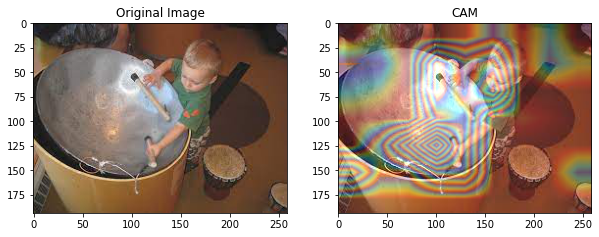

In [469]:
heatmap  = CAM(X[0], model)

### Guided Gradient Weighted Class Activation Maps

First thing to note that since we are using an adaptive pooling layer, both CAM and GRADCAM will yield the same results
since the weights are equal to the gradients anyway. so using the weights and the gradients are equivalent
we need only take the hadamard product of both at the end and then visualize


Text(0.5, 1.0, 'Guided GradCAM')

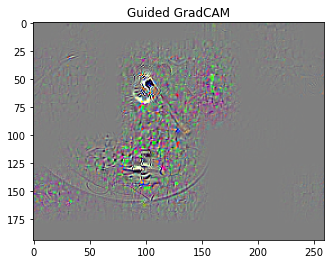

In [470]:
heatmap = np.stack((heatmap,)*3, axis=-1)
guided_gradcam =  heatmap* grad.permute(1, 2, 0).detach().numpy()
plt.imshow(normalize(guided_gradcam))
plt.title('Guided GradCAM')